## Python implementation of Monti-Hyv&auml;rinen Analysis (MHA) algorithm

#### The MHA model is an extension of traditional factor analytic and PCA models. In particular, MHA enjoys the following benefits over traditional methods such as PCA and factor analysis. 

#### TL;DR 
 * MHA is built to facilitate the interpretation of results. In particular, MHA introduces non-negativity and orthonormality constraints which effectively serve to cluster observations (e.g., ROIs in the fMRI example below)
 * MHA is designed to accomodate data across multiple subjects (e.g., fMRI data across a cohort of subjects as in the example below)
 * MHA is a latent variable model were we explicity allow latent variables to have a full covariance structure. This is in contrast to traditional latent variable models such as PCA, where latent variables are assumed to be independent.
 * Despite allowing latent variables to be correlated, MHA is identifiable - this means that the latent variables which generated the data can be recovered (up to some tolerable indeterminacies). 

#### For further details see:
 * Monti & Hyv&auml;rinen, "A unified probabilistic model for learning latent factors and their connectivities from high-dimensional data", UAI, 2018
 * Monti et al., "Interpretable brain age prediction using linear latent variable models of functional connectivity", arXiv:1908.01555, 2019

### Background: principal component analysis as a linear latent variable model

We assume that we have observations, $X^{(i)} \in \mathbb{R}^p$, across a cohort of subjects $i=1, \ldots, N$. Further, we assume that observations $X^{(i)} \in \mathbb{R}^p$ are generated as a linear projection from low-dimensional latent variables, $Z^{(i)} \in \mathbb{R}^k$. Such an assumption is widely employed and implicit in a wide range of methods such as PCA, factor analysis and ICA. 

Formally, models such as PCA and factor analysis assume that observations and latent variables follow a multivariate Gaussian distributions, thereby yielding the following generative model for observed data:
\begin{align}
    Z^{(i)} &\sim \mathcal{N}(0, G^{(i)}) \\
    X^{(i)} | Z^{(i)} =z^{(i)} &\sim  \mathcal{N}( W z^{(i)}, v^{(i)} I)
\end{align}
where $G^{(i)}\in \mathbb{R}^{k \times k}$ denoates the latent variable covariance matrix (assumed to be diagonal in PCA and factor analytic models) and $v^{(i)} \in \mathbb{R}_+$ denotes measurement noise. Note that the loading matrix, $W \in \mathbb{R}^{p \times k}$, is shared across all subjects whereas the latent variable covariance, $G^{(i)}$, varies from subject to subject.

Due to the fact that latent variables, $Z^{(i)}$, are Gaussian, they can be marginalized out. As such, the distribution over observations, $X^{(i)}$, is assumed to follow:
$$ X^{(i)} \sim \mathcal{N}(0, \Sigma^{(i)}), $$
where $ \Sigma^{(i)} = W G^{(i)} W^T + v^{(i)} I$. This implies that the loading matrix, $W$, captures low-rank covariance structure. 




### Proposed model

MHA directly extends the above model in two important ways:
 1. The loading matrix, $W$, is constrained to be non-negativity and orthonormal. This leads to a loading matrix with at most one non-zero entry per row. We may therefore interpret the columns of $W$ as encoding membership to $k$ non-overlapping modules or networks.
 2. It considers latent variables with non-diagonal covariance structure, termed _latent connectivities_. Whilst the columns of the loading matrix, $W$, encode module membership, we may interpret the covariance structure over latent variables as encoding marginal dependencies (i.e., connectivity) between various modules or networks.

A visualization of the MHA covariance model is provided below. Note that whilst the loading matrix is shared across all subjects, it is the subject-specific latent connectivities matrix, $G^{(i)}$, which characterizes inter-subject differences (in particular, differences in network connectivities from one subject to another).
<img src="MHAcovarianceModel.png">

#### Python implementation

In the remainder of this notebook we describe a python implementation of the MHA algorithm. An R version of this code is also available [here](http://www.gatsby.ucl.ac.uk/~ricardom/FactorCovariance_ScoreMatch_PenalizeLagrange.R).

The proposed implementation consists of an MHA object which has the following methods:
 - fit: estimate associated parameters, primarily loading matrix, $W$, and latent variable covariances
 - transform: project observations, $X^{(i)}$, to latent variables using inferred loading matrix $W$
 - plot: produce visualizations of estimated networks (relevant for fMRI data analysis)


In the remainder of this notebook we outline each of these methods with an example to resting-state fMRI data.

In [1]:
import numpy as np 
import os 
import pandas as pd 

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

from nilearn import plotting
from sklearn.preprocessing import scale 

%matplotlib inline

from MHA import MHA 

In [2]:
# load in CamCAN data
os.chdir('data/camCAN/')

files = os.listdir( os.getcwd() ) 
files = [f for f in files if '.csv' in f ]

SubDat = [ ( np.array( pd.read_csv(f) ) ) for f in files  ]
Shat = [ np.cov( scale(S).T ) for S in SubDat if np.isnan(S).sum()==0 ]

print( 'Collected data for ' + str( len( Shat ) ) + ' subjects' )

# also load in the MNI coordinates of regions
ROIcoord = np.loadtxt('../MNI.txt')    

Collected data for 564 subjects


In [3]:
# initialize MHA object and fit parameters
k=5
res = MHA( Shat=Shat, k=k, diagG=True )
res.fit( alphaArmijo=1 )

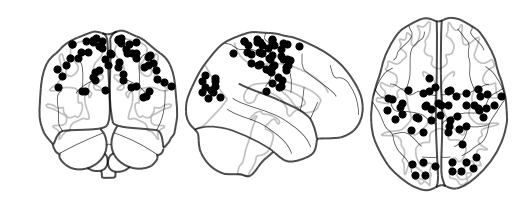

In [4]:
# visualize some of the estimated networks 
res.plot( ROIcoord, clusterID=0, title='' )

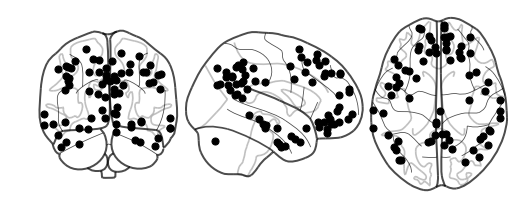

In [ ]:
res.plot( ROIcoord, clusterID=3, title='' )

In [ ]:
res.plot( ROIcoord, clusterID=1, title='' )

In [ ]:
res.plot( ROIcoord, clusterID=2, title='' )

In [ ]:
res.plot( ROIcoord, clusterID=4, title='' )